In [1]:
import os
import json
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]
plt.rcParams['font.size'] = 12

In [2]:
import pysam
import itertools

In [3]:
trgt_dir = "../10_trgt/output/"

In [4]:
def get_reads_by_allele(path):
    bam = pysam.AlignmentFile(path, "r")
    get_coord = lambda read: (read.reference_name, read.pos)
    for coord, reads in itertools.groupby(bam.fetch(until_eof=True), key=get_coord):
        reads = list(reads)
        reads_by_allele = [[] for _ in range(max(r.get_tag("AL") for r in reads) + 1)]
        for read in reads:
            reads_by_allele[read.get_tag("AL")].append(read.query_sequence)
        yield coord, reads_by_allele


def load_repeat_reads(chrom, start, path):
    for coord, reads_by_allele in get_reads_by_allele(path):
        if (chrom, start) == coord:
            return reads_by_allele
    assert False


In [5]:
def calc_mad(values):
    median = np.median(values)
    mad = np.median([abs(v - median) for v in values])
    return mad

In [6]:
lens_and_mads = []

for file in os.listdir(trgt_dir):
    if not file.endswith(".bam") or file.endswith(".spanning.bam"):
        continue
    reads_by_allele = load_repeat_reads("chrX", 147912050, os.path.join(trgt_dir, file))
    lens_by_allele = [[len(r) - 100 for r in reads] for reads in reads_by_allele]
    for lens in lens_by_allele:
        allele_len = np.median(lens)
        allele_mad = calc_mad(lens)
        lens_and_mads.append((allele_len, allele_mad))


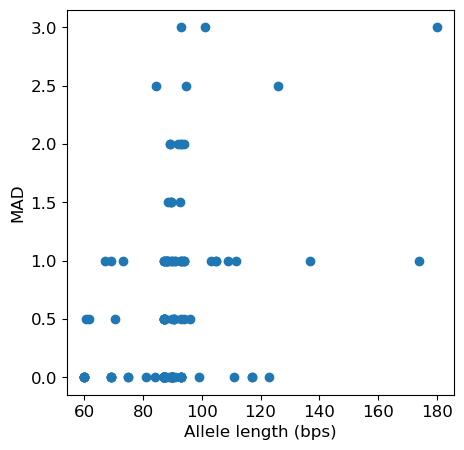

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
lens = [l for l, m in lens_and_mads]
mads = [m for l, m in lens_and_mads]

ax.scatter(lens, mads)
ax.set_xlabel("Allele length (bps)")
ax.set_ylabel("MAD");